If you are using VSCode, simply clone the repository in a container volume. Otherwise, you'll need standard Anaconda packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Helper functions for later

In [2]:
def get_dispatch(market, intercept, slope):
    return np.maximum(
        np.minimum(
            intercept + slope*market.Bid - market.Capacity.cumsum().shift(fill_value=0),
            market.Capacity
        ),
        0
    )

def visualize(market, intercept, slope, ax):
    ax.step(market.Capacity.cumsum(), market.Bid)
    ax.plot([intercept + slope*market.Bid.max(), intercept], [market.Bid.max(), 0])
    dispatched = market.loc[market.Dispatch > 0].iloc[-1]
    ax.hlines(
        dispatched['Total Marginal Cost'] + dispatched.Surplus/dispatched.Dispatch,
        ax.get_xlim()[0], ax.get_xlim()[1],
        color='black',
        linestyle='dashed'
    )
    print(dispatched['Total Marginal Cost'] + dispatched.Surplus/dispatched.Dispatch)
    ax.grid()

Load and process portfolio data

In [3]:
portfolios = pd.read_excel('ESG Portfolios.xlsx')
portfolios.columns = portfolios.iloc[0:3].bfill().iloc[0]
portfolios = portfolios.iloc[3:]
portfolios = portfolios[portfolios['UNIT NAME'] != 'Totals']
portfolios.dropna(axis='index', how='all', inplace=True)
portfolios.dropna(axis='columns', how='all', inplace=True)
portfolios['portfolio'] = (portfolios.isna().any(axis='columns') * portfolios['UNIT NAME']).replace('', np.NaN).ffill()
portfolios.dropna(axis='index', how='any', inplace=True)
portfolios.set_index(['Location', 'portfolio', 'UNIT NAME'], inplace=True)
portfolios.sort_index(axis='index',level=['Location', 'portfolio'], inplace=True)

Load and process profile data

In [4]:
profiles = pd.read_excel('ESG Demand Year 2.xlsx', header=2, index_col=[1,0,2])
profiles.dropna(axis='index', how='any', inplace=True)
profiles.sort_index(inplace=True)

``simulate`` accepts an hour and a bid, both of which are pandas ``Series`` objects with indices taken from the ``portfolios`` and ``profiles`` objects, respectively. It returns a copy of ``portfolios`` with dispatch and surplus results.

In [5]:
def simulate_hour(hour, bid, pay_as_bid, transmission_capacity, co2_tax):

    results = portfolios.copy()
    results['Bid'] = bid
    results.sort_values('Bid', inplace=True)
    results['Dispatch'] = get_dispatch(results, hour.sum()['Load Intercept'], hour.sum()['Load Slope'])

    generation = results.Dispatch.groupby('Location').sum()
    consumption = np.linalg.inv(
        np.array(
            [
                np.array([1,-1])*np.array([1/hour.loc[location, 'Load Slope'] for location in hour.index]),
                [1, 1]
            ]
        )
    )@np.array(
        [
            np.array([1, -1])@(hour['Load Intercept']/hour['Load Slope']),
            results.Dispatch.sum()
        ]
    )
    shortage = consumption - generation

    if np.abs(shortage).mean() >= transmission_capacity:

        shortage = transmission_capacity*np.sign(shortage)
        results.Dispatch = results.groupby('Location', group_keys=False).apply(
            lambda market: get_dispatch(
                market, hour.loc[market.name, 'Load Intercept'] 
                - shortage[market.name], hour.loc[market.name, 'Load Slope']
            )
        )
        generation = results.Dispatch.groupby('Location').sum()
        consumption = generation + shortage

    price = (consumption - hour['Load Intercept'])/hour['Load Slope']

    results['Surplus'] = results.groupby('Location', group_keys=False).apply(
        lambda market: market.Dispatch*(
            (market.Bid if pay_as_bid else price[market.name]) - market['Total Marginal Cost']
        ) 
    )

    results['Profit'] = results.groupby('Location', group_keys=False).apply(
        lambda market: market.Surplus
        - market.Dispatch*co2_tax*market.CO2
        - market['O&M/Day ($)']/4
    )
    return results

A wrapper function to simulate a full year given a bid profile

In [6]:
def simulate(bids):
    return profiles.groupby(['Day', 'Hour']).apply(
        lambda hour: simulate_hour(
            hour = hour.droplevel(['Day', 'Hour']), 
            bid = bids[hour.name],
            pay_as_bid = hour.name[0] == 1,
            transmission_capacity = 500 if hour.name[0] == 2 else 10000,
            co2_tax = 50*(hour.name[0] == 3)
        )
    )

As a baseline, bid marginal cost every hour.

In [7]:
bids = pd.DataFrame(
    {
        (day, hour): portfolios['Total Marginal Cost'] 
        + portfolios.CO2*50*(day == 3)
        for (day, hour) in profiles.index.droplevel('Location')
        }
)
bids.columns.rename(profiles.index.droplevel('Location').names, inplace=True)

To run a scenario, modify ``bids`` and then run ``simulate(bids)``. ``bids`` has the following format, which must be kept the same - only modify the values!

In [8]:
bids.loc[('South','Beachfront','MANDALAY 1&2'),(1,1)] = 39.49

bids.loc[('South','Beachfront','COOLWATER'),(1,2)] = 43.79
bids.loc[('South','Beachfront','ETIWANDA 1-4'),(1,2)] = 500

bids.loc[('South','Beachfront','MANDALAY 3'),(1,3)] = 52.49
bids.loc[('South','Beachfront','ETIWANDA 1-4'),(1,3)] = 500
bids.loc[('South','Beachfront','COOLWATER'),(1,3)] = 500

profiles.loc[(['North', 'South'], 1), 'Load Intercept'] *= .91
results = simulate(bids)

For the first hour, each generator with marginal cost less than the clearing price bids the clearing price (minus one cent). The resulting profit values are the results in the competitive case, which are a lower bound on our expected profits.

In [9]:
prices = results.loc[1].groupby('Hour').apply(
    lambda market: market[market.Dispatch > 0].iloc[-1]
)
prices = prices['Total Marginal Cost'] + prices.Surplus/prices.Dispatch
bids[1] = bids[1].apply(lambda row: np.maximum(row, prices-.01), axis='columns')

profiles.loc[(['North', 'South'], 1), 'Load Intercept'] *= 1.00/.91
results = simulate(bids)

In [10]:
results.loc[(1,3,'South','Beachfront')]

/tmp/ipykernel_21306/4263781081.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[(1,3,'South','Beachfront')]


,Fuel,Capacity,Heat Rate,Fuel Price,Fuel Cost,O&M/MWh,Total Marginal Cost,CO2,O&M/Day ($),Bid,Dispatch,Surplus,Profit
UNIT NAME,,,,,,,,,,,,,
ORMOND BEACH 2,Gas,700,8.345679,4.5,37.555556,0.5,38.055556,0.44,7000,52.48,700,10097.111111,8347.111111
ORMOND BEACH 1,Gas,700,8.345679,4.5,37.555556,0.5,38.055556,0.44,7000,52.48,700,10097.111111,8347.111111
MANDALAY 1&2,Gas,300,8.345679,4.5,37.555556,1.5,39.055556,0.44,1000,52.48,300,4027.333333,3777.333333
MANDALAY 3,Gas,150,11.234568,4.5,50.555556,1.5,52.055556,0.6,1000,52.49,150,65.166667,-184.833333
ETIWANDA 5,Gas,150,13.641975,4.5,61.388889,1.5,62.888889,0.72,1000,62.888889,0,0.0,-250.0
ELLWOOD,Gas,300,16.691358,4.5,75.111111,0.5,75.611111,0.89,0,75.611111,0,0.0,0.0
ETIWANDA 1-4,Gas,850,9.148148,4.5,41.166667,1.5,42.666667,0.49,4000,500.0,0,0.0,-1000.0
COOLWATER,Gas,650,9.308642,4.5,41.888889,0.5,42.388889,0.49,2000,500.0,0,0.0,-500.0


In [11]:
results.loc[(1,3,'South','Beachfront')].Surplus.sum()

/tmp/ipykernel_21306/3787200572.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[(1,3,'South','Beachfront')].Surplus.sum()


24286.72222222223

Plot the north and south markets together. Do this for days 1, 3, and 4.

61.16666666666667


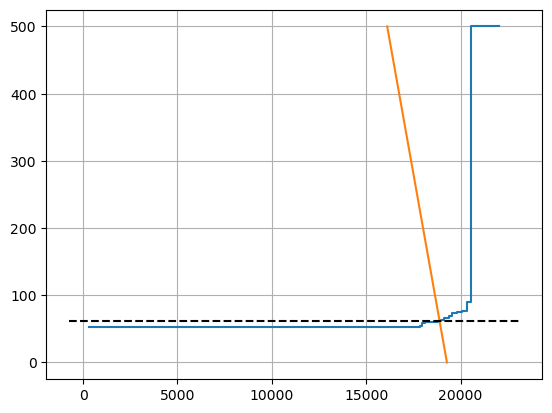

In [12]:
day = 1
hour = 3

fig, ax = plt.subplots()
hour_results = results.loc[day, hour]
(intercept, slope) = profiles.loc[(['North', 'South'], day, hour)].sum()
visualize(hour_results, intercept, slope, ax)
fig.show()

To check the market details for a certain day and location, run ``results.loc[day,hour,location]``, where ``location`` is either ``'North'`` or ``'South'``. For days 1, 3, and 4, simply omit the location argument and view the whole market.

In [13]:
results.loc[(1,3)]

0                                              Fuel Capacity  Heat Rate  \
Location portfolio    UNIT NAME                                           
North    Bay Views    MORRO BAY 1&2             Gas      335   8.506173   
South    Old Timers   MOHAVE 1                 Coal      750         10   
                      HIGHGROVE                 Gas      150   10.91358   
                      BIG CREEK               Hydro     1000          0   
         Big Gas      SOUTH BAY                 Gas      700    9.62963   
                      ENCINA                    Gas      950   9.148148   
                      EL SEGUNDO 3&4            Gas      650    8.82716   
                      EL SEGUNDO 1&2            Gas      400    9.62963   
         Big Coal     REDONDO 7&8               Gas      950   8.987654   
                      REDONDO 5&6               Gas      350   8.987654   
                      HUNTINGTON BEACH 1&2      Gas      300   8.666667   
                      FOUR CORNERS             Coal     1900  11.666667   
         Beachfront   ORMOND BEACH 2            Gas      700   8.345679   
                      ORMOND BEACH 1            Gas      700   8.345679   
         Old Timers   MOHAVE 2                 Coal      750         10   
         Beachfront   MANDALAY 1&2              Gas      300   8.345679   
North    Bay Views    MORRO BAY 3&4             Gas      665   8.024691   
                      MOSS LANDING 6            Gas      750   6.901235   
                      MOSS LANDING 7            Gas      750   6.901235   
         Fossil Light HUNTERS POINT 1&2         Gas      150  10.592593   
                      HUMBOLDT                  Gas      150  10.432099   
                      HELMS                   Hydro      800          0   
                      DIABLO CANYON 1       Nuclear     1000          1   
         East Bay     CONTRA COSTA 6&7          Gas      700   8.666667   
                      PITTSBURGH 1-4            Gas      650   8.987654   
                      PITTSBURGH 5&6            Gas      650   8.024691   
South    Beachfront   MANDALAY 3                Gas      150  11.234568   
         Big Gas      LONG BEACH                Gas      550  11.555556   
         Old Timers   SAN BERNADINO             Gas      100  11.876543   
North    East Bay     CONTRA COSTA 4&5          Gas      150  12.839506   
                      PITTSBURGH 7              Gas      700  13.160494   
         Bay Views    OAKLAND                   Gas      150  13.481481   
South    Beachfront   ETIWANDA 5                Gas      150  13.641975   
         Big Gas      NORTH ISLAND              Gas      150  14.444444   
         Big Coal     HUNTINGTON BEACH 5        Gas      150  14.444444   
North    East Bay     POTRERO HILL              Gas      150  15.407407   
South    Big Coal     ALAMITOS 7                Gas      250  16.049383   
         Beachfront   ELLWOOD                   Gas      300  16.691358   
North    Fossil Light HUNTERS POINT 4           Gas      250  16.530864   
South    Big Gas      KEARNY                    Gas      200  19.901235   
         Beachfront   ETIWANDA 1-4              Gas      850   9.148148   
                      COOLWATER                 Gas      650   9.308642   

0                                          Fuel Price  Fuel Cost O&M/MWh  \
Location portfolio    UNIT NAME                                            
North    Bay Views    MORRO BAY 1&2               4.5  38.277778     0.5   
South    Old Timers   MOHAVE 1                      3         30     4.5   
                      HIGHGROVE                   4.5  49.111111     0.5   
                      BIG CREEK                     0          0       0   
         Big Gas      SOUTH BAY                   4.5  43.333333     0.5   
                      ENCINA                      4.5  41.166667     0.5   
                      EL SEGUNDO 3&4              4.5  39.722222     1.5   
               

Finally, to check the single-hour surplus, run the following cell. Keep ``day`` and ``hour`` as variables - that is, only change their values, not the third line.

In [14]:
day = 4
hour = 1
results.loc[day, hour].groupby('portfolio').apply(
    lambda market: (market.Surplus - market.Dispatch*50*market.CO2*(day == 3)).sum()
)

portfolio
Bay Views       15079.722222
Beachfront       3855.555556
Big Coal         7600.000000
Big Gas            -0.000000
East Bay         3227.777778
Fossil Light    61000.000000
Old Timers      49500.000000
dtype: float64